# Label scores analyses

This notebook performs the following analysis steps:
* aggregating data across seeds, by phenomenon, by model, by label type
* transforming raw metrics into probabilities by item by metric
    * this requires working by-phenomenon, because there are different numbers of options in the different phenomena
* combining this data into one cleaned data file with binarized options (probabilities of target vs rest)
    * long formatting of options and of metrics
* averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
* plotting results by metric, by phenomenon, by model, by label type

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [117]:
# read data and combine
model_names = ["llama2", "flan-t5-xl", "gpt-3.5-turbo-instruct"]
label_types = ["label_alpha", "label_numeric"]

raw_df = pd.DataFrame()
for model in model_names:
    print("Model ", model)
    for label_type in label_types:
        results_path = glob.glob(f"../results/log_probs/{model}/*/label_scores/{label_type}/*.csv")
        print("Number of files to concat ", len(results_path))
        for p in results_path:
#             print("Reading file ", p)
            d = pd.read_csv(p)
            d["metric"] = "label_score"
            d["label_type"] = label_type
            
            raw_df = pd.concat([raw_df, d])    

Model  llama2
Number of files to concat  35
Number of files to concat  35
Model  flan-t5-xl
Number of files to concat  35
Number of files to concat  35
Model  gpt-3.5-turbo-instruct
Number of files to concat  35
Number of files to concat  31


In [118]:
print(len(raw_df))
raw_df.head()

19330


,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,...,token_probs,sentence_cond_probs,mean_sentence_cond_probs,prior_sentence_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,metric,label_type
0,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,A,target,...,[0.0021805406873923253],0.003313,0.003313,0.002181,1.519248,-5.709967,-5.709967,0.931755,label_score,label_alpha
1,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,B,incorrect_straightforward,...,[0.0018741641342209612],0.002067,0.002067,0.001874,1.103044,-6.181519,-6.181519,0.984382,label_score,label_alpha
2,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,C,associative_nonsequitur,...,[0.003587298613933627],0.001646,0.001646,0.003587,0.458951,-6.409168,-6.409168,1.138324,label_score,label_alpha
3,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,D,funny_nonsequitur,...,[0.002218916267492813],0.001804,0.001804,0.002219,0.812816,-6.317986,-6.317986,1.033916,label_score,label_alpha
4,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,E,neutral_nonsequitur,...,[0.0014657024465339016],0.000984,0.000984,0.001466,0.671308,-6.923948,-6.923948,1.061073,label_score,label_alpha


In [18]:
raw_df.columns

Index(['model_name', 'temperature', 'seed', 'item_id', 'phenomenon', 'prompt',
       'prior_prompt', 'question', 'options', 'option_names',
       'shuffled_options', 'shuffled_option_names', 'option_numbering',
       'token_cond_log_probs', 'token_cond_probs', 'prior_token_log_probs',
       'null_prior_token_log_probs', 'token_probs', 'sentence_cond_probs',
       'mean_sentence_cond_probs', 'prior_sentence_probs', 'sentence_mi',
       'sentence_surprisal', 'mean_sentence_surprisal',
       'sentence_mi_surprisal', 'metric', 'label_type'],
      dtype='object')

In [119]:
coherence_df = raw_df[raw_df['phenomenon'] == 'coherence']
deceits_df = raw_df[raw_df['phenomenon'] == 'deceits']
humours_df = raw_df[raw_df['phenomenon'] == 'humour']
indirect_df = raw_df[raw_df['phenomenon'] == 'indirect_speech']
irony_df = raw_df[raw_df['phenomenon'] == 'irony']
maxims_df = raw_df[raw_df['phenomenon'] == 'maxims']
metaphor_df = raw_df[raw_df['phenomenon'] == 'metaphor']

For the sanity check, here are the expected numbers of rows in each phenomenon, computed as: models * seed * items * options

* coherence: 3 * 5 * 40 * 2 = 1200 => 2400
* deceits: 3 * 5 * 20 * 4 = 1200 => 2400
* humour: 3 * 5 * 25 * 5 = 1875 => 3750
* indirect: 3 * 5 * 20 * 4 = 1200 => 2400
* irony: 3 * 5 * 25 * 4 = 1500 => 3000
* maxims: 3 * 5 * 19 * 4 = 1140 => 2280
* metaphor: 3 * 5 * 20 * 5 = 1500 => 3000

And for each x 2 for the numeric and alpha labels.

In [128]:
# somehow irony has 100 duplicate entries -- exclude
irony_df = irony_df.drop_duplicates()
len(irony_df)

3000

In [129]:
def transform_to_wide_and_softmax(df, option_names = ['target', 'competitor']):
    """
    Helper function for pivoting dataframes 
    to wide format and transforming metric results into 
    probabilities.
    Metric columns are collected into long format first for this.
    """
    # pivot all the metrics into one column
    df_subset = df[["model_name", "seed", "item_id", "phenomenon", "shuffled_option_names", "sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal", "metric", "label_type"]]
    df_subset = df_subset.rename(columns={
        "sentence_cond_probs": "value_sentence_cond_probs", 
        "mean_sentence_cond_probs": "value_mean_sentence_cond_probs", 
        "sentence_mi": "value_sentence_mi", 
        "sentence_surprisal": "value_sentence_surprisal", 
        "mean_sentence_surprisal": "value_mean_sentence_surprisal", 
        "sentence_mi_surprisal": "value_sentence_mi_surprisal"
    })
#     print(df_subset.head(5))
    df_long = pd.wide_to_long(
        df_subset, 
        stubnames="value_", 
        i=["model_name", "seed", "item_id", "phenomenon", "shuffled_option_names", "metric", "label_type"], 
        j="metric_formula",
        suffix='\\w+', 
    )
    df_long = df_long.reset_index()
    # fill NAs with 0
    df_long['value_'] = df_long["value_"].fillna(0)
    
    # spread different response options so that softmax can be applied
    df_wide = df_long.pivot_table(
        index=["model_name", "seed", "item_id", "phenomenon","metric", "label_type", "metric_formula"],
        columns="shuffled_option_names",
        values="value_"
    )
    df_wide = df_wide.reset_index()
    
    # softmax options over response option types
    df_wide["denominator"] = df_wide[option_names].sum(axis=1)
    for o in option_names:
        df_wide[o] = df_wide[o]/df_wide["denominator"]
        
    return df_wide

In [101]:
# len(irony_df)
#2300 / 3 / 25
# models, items, labels, seeds
3 * 25 * 2 * 5 * 4
indirect_df["model_name"].value_counts()

meta-llama/Llama-2-7b-hf    800
gpt-3.5-turbo-instruct      640
google/flan-t5-xl           320
Name: model_name, dtype: int64

In [130]:
# apply the helper to all phenomena
coherence_processed = transform_to_wide_and_softmax(coherence_df)
deceits_processed = transform_to_wide_and_softmax(deceits_df, ["target", "incorrect_literal", "incorrect_lexical_overlap", "incorrect_social_convention"])
humours_processed = transform_to_wide_and_softmax(humours_df, ["target", "incorrect_straightforward", "associative_nonsequitur", "funny_nonsequitur", "neutral_nonsequitur"])
indirect_processed = transform_to_wide_and_softmax(indirect_df, ["target", "competitor", "distractor_lexical_overlap", "distractor_associative"])
irony_processed = transform_to_wide_and_softmax(irony_df, ["target", "competitor", "distractor_associate", "distractor_nonsequitur"])
maxims_processed = transform_to_wide_and_softmax(maxims_df, ["target", "incorrect_literal", "incorrect_nonliteral", "incorrect_associate"])
metaphor_processed = transform_to_wide_and_softmax(metaphor_df, ["target", "competitor", "distractor_plausibleliteral", "distractor_literal", "distractor_nonsequitut"])

In [145]:
# binarize the processed data into target vs non-target probability
def binarize_df(df):
    df["distractor_prob"] = 1 - df["target"]
    df_subset = df[['metric_formula', "model_name", "seed", "item_id", "phenomenon", "metric", "label_type", "target", "distractor_prob"]]
    
    return df_subset

In [146]:
coherence_binary = binarize_df(coherence_processed)
deceits_binary = binarize_df(deceits_processed)
humours_binary = binarize_df(humours_processed)
indirect_binary = binarize_df(indirect_processed)
irony_binary = binarize_df(irony_processed)
maxims_binary = binarize_df(maxims_processed)
metaphor_binary = binarize_df(metaphor_processed)

In [149]:
# combine all into one cleaned file
label_scores = pd.concat([coherence_binary,deceits_binary,humours_binary,indirect_binary,irony_binary, maxims_binary,metaphor_binary])

In [152]:
# label_scores.to_csv("../results/log_probs/label_scores_all_cleaned_binarized.csv", index=False)
label_scores.head()

shuffled_option_names,metric_formula,model_name,seed,item_id,phenomenon,metric,label_type,target,distractor_prob
0,mean_sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.5,0.5
1,mean_sentence_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.5,0.5
2,sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.5,0.5
3,sentence_mi,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.5,0.5
4,sentence_mi_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.5,0.5


In [156]:
# analyse the data
# averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
scores_binary_summary = label_scores.groupby(["model_name", "metric_formula", "phenomenon", "label_type"]).mean(["target", "distractor_prob"]).reset_index()

In [157]:
# same thing by phenomenon
# TODO

shuffled_option_names,model_name,metric_formula,phenomenon,label_type,seed,item_id,target,distractor_prob
0,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_alpha,2.0,20.5,0.50,0.50
1,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_numeric,2.0,20.5,0.50,0.50
2,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_alpha,2.0,10.5,0.25,0.75
3,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_numeric,2.0,10.5,0.25,0.75
4,google/flan-t5-xl,mean_sentence_cond_probs,humour,label_alpha,2.0,13.0,0.20,0.80
...,...,...,...,...,...,...,...,...
79,google/flan-t5-xl,sentence_surprisal,irony,label_numeric,2.0,13.0,0.25,0.75
80,google/flan-t5-xl,sentence_surprisal,maxims,label_alpha,2.0,10.0,0.25,0.75
81,google/flan-t5-xl,sentence_surprisal,maxims,label_numeric,2.0,10.0,0.25,0.75
82,google/flan-t5-xl,sentence_surprisal,metaphor,label_alpha,2.0,10.5,0.20,0.80


In [165]:
# read human results for the "correlation plot"
df_human_coherence = pd.read_csv("../data/human_results/Human_CoherenceInference.csv") 
df_human_coherence["phenomenon"] = "coherence"
df_human_deceits = pd.read_csv("../data/human_results/Human_Deceits.csv") 
df_human_deceits["phenomenon"] = "deceits"
df_human_humour = pd.read_csv("../data/human_results/Human_Humour.csv") 
df_human_humour["phenomenon"] = "humour"
df_human_indirect = pd.read_csv("../data/human_results/Human_IndirectSpeech.csv") 
df_human_indirect["phenomenon"] = "indirect_speech"
df_human_irony = pd.read_csv("../data/human_results/Human_Irony.csv") 
df_human_irony["phenomenon"] = "irony"
df_human_metaphor = pd.read_csv("../data/human_results/Human_Metaphor.csv") 
df_human_metaphor["phenomenon"] = "metaphor"
df_human_maxims = pd.read_csv("../data/human_results/Human_Maxims.csv") 
df_human_maxims["phenomenon"] = "maxims"

In [166]:
df_human_all = pd.concat([df_human_coherence, df_human_deceits, df_human_humour, df_human_indirect, df_human_irony, df_human_metaphor, df_human_maxims])

In [167]:
df_human_summary = df_human_all.groupby(["phenomenon"]).mean("Correct")


In [175]:
df_human_summary = df_human_summary.reset_index()
df_human_summary

,phenomenon,Unnamed: 0,pKey,itemNum,Correct
0,coherence,7480.5,274.371658,20.5,0.856684
1,deceits,3740.5,274.371658,10.5,0.841979
2,humour,4675.5,274.371658,13.0,0.846845
3,indirect_speech,3740.5,274.371658,10.5,0.885963
4,irony,4675.5,274.371658,13.0,0.919465
5,maxims,3740.5,274.371658,10.5,0.795856
6,metaphor,3740.5,274.371658,10.5,0.896791


In [190]:
# add human proportion to model summary
scores_binary_summary_wHuman = scores_binary_summary.copy()

for i, r in scores_binary_summary_wHuman.iterrows():
    phenomenon = r['phenomenon']
    val = float(df_human_summary[df_human_summary["phenomenon"] == phenomenon]['Correct'])
    scores_binary_summary_wHuman.loc[i, 'human'] = val

ph  coherence
ph  coherence
ph  deceits
ph  deceits
ph  humour
ph  humour
ph  indirect_speech
ph  indirect_speech
ph  irony
ph  irony
ph  maxims
ph  maxims
ph  metaphor
ph  metaphor
ph  coherence
ph  coherence
ph  deceits
ph  deceits
ph  humour
ph  humour
ph  indirect_speech
ph  indirect_speech
ph  irony
ph  irony
ph  maxims
ph  maxims
ph  metaphor
ph  metaphor
ph  coherence
ph  coherence
ph  deceits
ph  deceits
ph  humour
ph  humour
ph  indirect_speech
ph  indirect_speech
ph  irony
ph  irony
ph  maxims
ph  maxims
ph  metaphor
ph  metaphor
ph  coherence
ph  coherence
ph  deceits
ph  deceits
ph  humour
ph  humour
ph  indirect_speech
ph  indirect_speech
ph  irony
ph  irony
ph  maxims
ph  maxims
ph  metaphor
ph  metaphor
ph  coherence
ph  coherence
ph  deceits
ph  deceits
ph  humour
ph  humour
ph  indirect_speech
ph  indirect_speech
ph  irony
ph  irony
ph  maxims
ph  maxims
ph  metaphor
ph  metaphor
ph  coherence
ph  coherence
ph  deceits
ph  deceits
ph  humour
ph  humour
ph  indirect_spe

<AxesSubplot:xlabel='human', ylabel='target'>

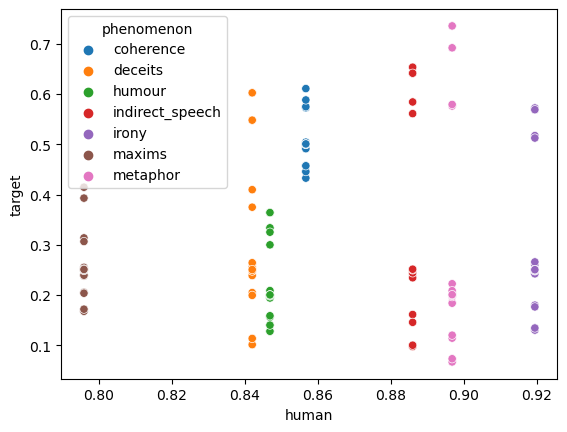

In [195]:
# plotting results by metric, by phenomenon, by model, by label type 
# TODO
scores_binary_summary_wHuman
sns.scatterplot(data=scores_binary_summary_wHuman, x="human", y="target", hue="phenomenon")